In [1]:
import os
import numpy as np
import pandas as pd 
import random
import cv2
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.layers import Conv2D, SeparableConv2D, MaxPool2D, LeakyReLU, Activation, ZeroPadding2D, Add,add,AveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.utils import plot_model
import imgaug as ia
import imgaug.augmenters as iaa


from os import listdir
from os.path import isfile, join
from PIL import Image
import glob


seed = 2019
np.random.seed(seed)
%matplotlib inline

In [2]:
tf.__version__

'2.1.0'

In [3]:

dirname = ''
train_path = os.path.join(dirname, 'OCT2017/train')
train_normal_path = os.path.join(train_path, 'NORMAL')
train_dme_path = os.path.join(train_path, 'DME')
train_drusen_path = os.path.join(train_path, 'DRUSEN')
train_cnv_path = os.path.join(train_path, 'CNV')
    
test_path = os.path.join(dirname, 'OCT2017/test')
test_normal_path = os.path.join(test_path, 'NORMAL')
test_dme_path = os.path.join(test_path, 'DME')
test_drusen_path = os.path.join(test_path, 'DRUSEN')
test_cnv_path = os.path.join(test_path, 'CNV')
    
val_path = os.path.join(dirname, 'OCT2017/val')
val_normal_path = os.path.join(val_path, 'NORMAL')
val_dme_path = os.path.join(val_path, 'DME')
val_drusen_path = os.path.join(val_path, 'DRUSEN')
val_cnv_path = os.path.join(val_path, 'CNV')



In [4]:
def plot_imgs(dir_path):
    all_dirs = os.listdir(dir_path)
    
    # take the first 4 images to plot
    required_imgs = [os.path.join(dir_path, f) for f in all_dirs][:4]

    plt.figure(figsize=(16, 16))
    for idx, img_path in enumerate(required_imgs):
        plt.subplot(1, 4, idx+1)

        img = cv2.imread(img_path)
        #img_eq = cv2.equalizeHist(img)
        
        plt.imshow(img)

    plt.tight_layout()

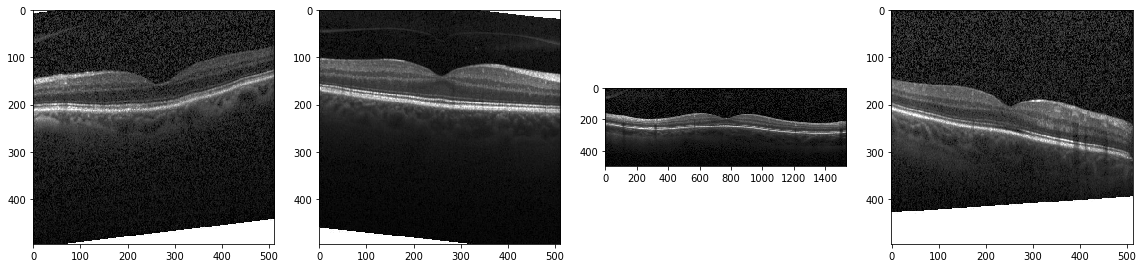

In [5]:
plot_imgs(test_normal_path)

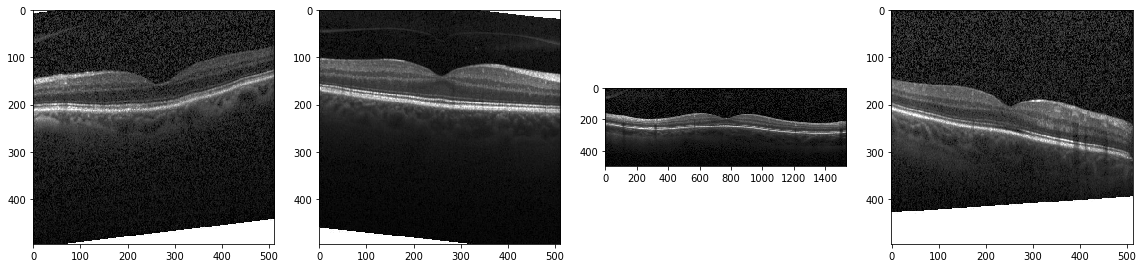

In [6]:
plot_imgs(test_normal_path)

In [ ]:
def Images_details_Print_data(data, path):
    print(" ====== Images in: ", path)    
    for k, v in data.items():
        print("%s:\t%s" % (k, v))

def Images_details(path):
    files = [f for f in glob.glob(path + "**/*.*", recursive=True)]
    data = {}
    data['images_count'] = len(files)
    data['min_width'] = 10**100  # No image will be bigger than that
    data['max_width'] = 0
    data['min_height'] = 10**100  # No image will be bigger than that
    data['max_height'] = 0


    for f in files:
        im = Image.open(f)
        width, height = im.size
        data['min_width'] = min(width, data['min_width'])
        data['min_height'] = min(height, data['min_height'])
        data['max_width'] = max(width, data['max_height'])
        
        data['max_height'] = max(height, data['max_height'])

    Images_details_Print_data(data, path)

In [ ]:
Images_details(train_normal_path)
Images_details(train_dme_path)
Images_details(train_drusen_path)
Images_details(train_cnv_path)



In [4]:
input_path = "OCT2017/"

for _set in ['train', 'test', 'val']:
    normal = len(os.listdir(input_path + _set + '/NORMAL'))
    dme = len(os.listdir(input_path + _set + '/DME'))
    drusen = len(os.listdir(input_path + _set + '/DRUSEN'))
    cnv = len(os.listdir(input_path + _set + '/CNV'))
    print('{}, Normal images: {}, DME images: {}, DRUSEN images: {}, CNV images: {}'.format(_set, normal, dme, drusen, cnv))

train, Normal images: 20798, DME images: 9029, DRUSEN images: 6724, CNV images: 30509
test, Normal images: 5518, DME images: 2402, DRUSEN images: 1962, CNV images: 6706
val, Normal images: 136, DME images: 136, DRUSEN images: 136, CNV images: 136


In [4]:
import imgaug as ia
import imgaug.augmenters as iaa

seq = iaa.Sequential([
        iaa.Fliplr(0.5),
        iaa.Flipud(0.5),
        iaa.Invert(0.2),
        #iaa.Rotate((-45, 45)),
        #iaa.GaussianBlur(sigma=(0, 3.0)) 
        #iaa.Alpha((0.0, 1.0), iaa.AllChannelsHistogramEqualization())
        # blur images with a sigma of 0 to 3.0
    ])

def augment(img):
        seq_det = seq.to_deterministic()
        
        aug_image = seq_det.augment_image(img)
        return aug_image
    
def process_data(img_dims, batch_size):
    train_datagen = ImageDataGenerator(
        rescale = 1./255,
      #  featurewise_center=True,
      #  featurewise_std_normalization=True,
        zoom_range = 0.3,
        horizontal_flip = True
        #preprocessing_function = augment 
    )
    
    test_datagen = ImageDataGenerator(
      #  featurewise_center=True,
      #  featurewise_std_normalization=True,
        rescale=1./255)
    
    train_gen = train_datagen.flow_from_directory(
                                    directory=train_path, 
                                    target_size=(img_dims,img_dims),
                                    batch_size=batch_size, 
                                    class_mode='categorical', 
                                    shuffle=True)

    test_gen = test_datagen.flow_from_directory(
                                    directory=val_path, 
                                    target_size=(img_dims,img_dims), 
                                    batch_size=batch_size, 
                                    class_mode='categorical', 
                                    shuffle=True)
    
    return train_gen, test_gen

In [5]:
PARAMS = {'img_dims': 160,
          'epochs': 35,
          'batch_size': 32,
          'optimizer': 'adam',
          'loss': 'categorical_crossentropy',
          'metrics': 'categorical_accuracy',
          }


In [6]:
#train_gen, test_gen, test_data, test_labels = process_data(PARAMS['img_dims'], PARAMS['batch_size'])

config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.compat.v1.InteractiveSession(config=config)
USE_GPU = True

if USE_GPU:
    device = '/device:GPU:0'
else:
    device = '/cpu:0'

# Constant to control how often we print when training models
print_every = 100

train_gen, test_gen = process_data(PARAMS['img_dims'], PARAMS['batch_size'])
inputs = Input(shape=(PARAMS['img_dims'], PARAMS['img_dims'], 3))


Found 82811 images belonging to 4 classes.
Found 544 images belonging to 4 classes.


In [7]:
def identity_block(X, f, filters):

    
    # Retrieve Filters
    F1, F2, F3 = filters
    
    F1 = F1 // 4 
    F2 = F2 // 4
    F3 = F3 // 4
    
    # Save the input value
    X_shortcut = X
    
    # First component of main path
    X1 = Conv2D(filters = F1, kernel_size = (1, 1), strides = (1,1), padding = 'valid')(X)
    X1 = BatchNormalization(axis = 3)(X1)
    X1 = Activation('relu')(X1)
    
    X2 = Conv2D(filters = F1, kernel_size = (1, 1), strides = (1,1), padding = 'valid')(X)
    X2 = BatchNormalization(axis = 3)(X2)
    X2 = Activation('relu')(X2)
    
    X3 = Conv2D(filters=F1, kernel_size=(1, 1), strides=(1, 1), padding='valid')(X)
    X3 = BatchNormalization(axis=3)(X3)
    X3 = Activation('relu')(X3)
    
    X4 = Conv2D(filters=F1, kernel_size=(1, 1), strides=(1, 1), padding='valid')(X)
    X4 = BatchNormalization(axis=3)(X4)
    X4 = Activation('relu')(X4)
    
    X5 = Conv2D(filters=F1, kernel_size=(1, 1), strides=(1, 1), padding='valid')(X)
    X5 = BatchNormalization(axis=3)(X5)
    X5 = Activation('relu')(X5)
    
    X6 = Conv2D(filters=F1, kernel_size=(1, 1), strides=(1, 1), padding='valid')(X)
    X6 = BatchNormalization(axis=3)(X6)
    X6 = Activation('relu')(X6)
    
    # Second component of main path
    X1 = Conv2D(filters = F2, kernel_size = (f, f), strides = (1, 1), padding = 'same')(X1)
    X1 = BatchNormalization(axis = 3)(X1)
    X1 = Activation('relu')(X1)
    
    X2 = Conv2D(filters = F2, kernel_size = (f, f), strides = (1, 1), padding = 'same')(X2)
    X2 = BatchNormalization(axis = 3,)(X2)
    X2 = Activation('relu')(X2)
    
    X3 = Conv2D(filters=F2, kernel_size=(f, f), strides=(1, 1), padding='same')(X3)
    X3 = BatchNormalization(axis=3)(X3)
    X3 = Activation('relu')(X3)
    
    X4 = Conv2D(filters=F2, kernel_size=(f, f), strides=(1, 1), padding='same')(X4)
    X4 = BatchNormalization(axis=3)(X4)
    X4 = Activation('relu')(X4)
    
    X5 = Conv2D(filters=F2, kernel_size=(f, f), strides=(1, 1), padding='same')(X5)
    X5 = BatchNormalization(axis=3)(X5)
    X5 = Activation('relu')(X5)

    X6 = Conv2D(filters=F2, kernel_size=(f, f), strides=(1, 1), padding='same')(X6)
    X6 = BatchNormalization(axis=3)(X6)
    X6 = Activation('relu')(X6)
    
    # Third component of main path 
    X1 = Conv2D(filters = F3, kernel_size = (1, 1), strides = (1, 1), padding = 'valid')(X1)
    X1 = BatchNormalization(axis = 3)(X1)
    
    X2 = Conv2D(filters = F3, kernel_size = (1, 1), strides = (1, 1), padding = 'valid')(X2)
    X2 = BatchNormalization(axis = 3)(X2)
    
    X3 = Conv2D(filters=F3, kernel_size=(1, 1), strides=(1, 1), padding='valid')(X3)
    X3 = BatchNormalization(axis=3)(X3)
    
    X4 = Conv2D(filters=F3, kernel_size=(1, 1), strides=(1, 1), padding='valid')(X4)
    X4 = BatchNormalization(axis=3)(X4)
    
    X5 = Conv2D(filters=F3, kernel_size=(1, 1), strides=(1, 1), padding='valid')(X5)
    X5 = BatchNormalization(axis=3)(X5)
    
    X6 = Conv2D(filters=F3, kernel_size=(1, 1), strides=(1, 1), padding='valid')(X6)
    X6 = BatchNormalization(axis=3)(X6)

    # Final step: Add shortcut value to main path, and pass it through a RELU activation
    X = Add()([X1, X2,X3,X4,X5,X6])
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)
    
    return X

In [8]:
def convolutional_block(X, f, filters, s=2):


    # Retrieve Filters
    F1, F2, F3 = filters
    
    F1 = F1 // 4
    F2 = F2 // 4
    F3 = F3 // 4

    # Save the input value
    X_shortcut = X

    ##### MAIN PATH #####
    # First component of main path 
    X1 = Conv2D(filters=F1, kernel_size=(1, 1), strides=(s, s), padding='valid')(X)
    X1 = BatchNormalization(axis=3)(X1)
    X1 = Activation('relu')(X1)
    
    X2 = Conv2D(filters=F1, kernel_size=(1, 1), strides=(s, s), padding='valid')(X)
    X2 = BatchNormalization(axis=3)(X2)
    X2 = Activation('relu')(X2)

    X3 = Conv2D(filters=F1, kernel_size=(1, 1), strides=(s, s), padding='valid')(X)
    X3 = BatchNormalization(axis=3)(X3)
    X3 = Activation('relu')(X3)
    
    X4 = Conv2D(filters=F1, kernel_size=(1, 1), strides=(s, s), padding='valid')(X)
    X4 = BatchNormalization(axis=3)(X4)
    X4 = Activation('relu')(X4)
    
    X5 = Conv2D(filters=F1, kernel_size=(1, 1), strides=(s, s), padding='valid')(X)
    X5 = BatchNormalization(axis=3)(X5)
    X5 = Activation('relu')(X5)
    
    X6 = Conv2D(filters=F1, kernel_size=(1, 1), strides=(s, s), padding='valid')(X)
    X6 = BatchNormalization(axis=3)(X6)
    X6 = Activation('relu')(X6)
    
    # Second component of main path
    X1 = Conv2D(filters=F2, kernel_size=(f, f), strides=(1, 1), padding='same')(X1)
    X1 = BatchNormalization(axis=3)(X1)
    X1 = Activation('relu')(X1)
    
    X2 = Conv2D(filters=F2, kernel_size=(f, f), strides=(1, 1), padding='same')(X2)
    X2 = BatchNormalization(axis=3)(X2)
    X2 = Activation('relu')(X2)
    
    X3 = Conv2D(filters=F2, kernel_size=(f, f), strides=(1, 1), padding='same')(X3)
    X3 = BatchNormalization(axis=3)(X3)
    X3 = Activation('relu')(X3)
    
    X4 = Conv2D(filters=F2, kernel_size=(f, f), strides=(1, 1), padding='same')(X4)
    X4 = BatchNormalization(axis=3)(X4)
    X4 = Activation('relu')(X4)
    
    X5 = Conv2D(filters=F2, kernel_size=(f, f), strides=(1, 1), padding='same')(X5)
    X5 = BatchNormalization(axis=3)(X5)
    X5 = Activation('relu')(X5)
    
    X6 = Conv2D(filters=F2, kernel_size=(f, f), strides=(1, 1), padding='same')(X6)
    X6 = BatchNormalization(axis=3)(X6)
    X6 = Activation('relu')(X6)

    # Third component of main path
    X1 = Conv2D(filters=F3, kernel_size=(1, 1), strides=(1, 1), padding='valid')(X1)
    X1 = BatchNormalization(axis=3)(X1)
    
    X2 = Conv2D(filters=F3, kernel_size=(1, 1), strides=(1, 1), padding='valid')(X2)
    X2 = BatchNormalization(axis=3)(X2)
    
    X3 = Conv2D(filters=F3, kernel_size=(1, 1), strides=(1, 1), padding='valid')(X3)
    X3 = BatchNormalization(axis=3)(X3)
    
    X4 = Conv2D(filters=F3, kernel_size=(1, 1), strides=(1, 1), padding='valid')(X4)
    X4 = BatchNormalization(axis=3)(X4)
    
    X5 = Conv2D(filters=F3, kernel_size=(1, 1), strides=(1, 1), padding='valid')(X5)
    X5 = BatchNormalization(axis=3)(X5)
    
    X6 = Conv2D(filters=F3, kernel_size=(1, 1), strides=(1, 1), padding='valid')(X6)
    X6 = BatchNormalization(axis=3)(X6)

    X = Add()([X1, X2,X3,X4,X5,X6])
    
    ##### SHORTCUT PATH #### 
    X_shortcut = Conv2D(filters=F3, kernel_size=(1, 1), strides=(s, s), padding='valid')(X_shortcut)
    X_shortcut = BatchNormalization(axis=3)(X_shortcut)

    # Final step: Add shortcut value to main path, and pass it through a RELU activation
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)

    return X

In [9]:
filters= [(64, 64, 256),(128, 128, 512),(256, 256, 1024),(512, 512, 2048)]

X = ZeroPadding2D((3,3))(inputs)
# First conv block
X = Conv2D(64, (7, 7), strides = (2, 2), name = 'conv1')(X)
X = BatchNormalization(axis = 3, name = 'bn_conv1')(X)
X = Activation('relu')(X)
X = MaxPool2D((3, 3), strides=(2, 2))(X)


# Stage 2
X = convolutional_block(X, f = 3, filters = filters[0] )
X = identity_block(X, 3,filters[0])
X = identity_block(X, 3,filters[0])
# Stage 3
X = convolutional_block(X, f=3, filters=filters[1])
X = identity_block(X, 3, filters[1])
X = identity_block(X, 3, filters[1])
X = identity_block(X, 3, filters[1])

# Stage 4
X = convolutional_block(X, f=3, filters=filters[2])
X = identity_block(X, 3, filters[2])
X = identity_block(X, 3, filters[2])
X = identity_block(X, 3, filters[2])
X = identity_block(X, 3, filters[2])
X = identity_block(X, 3, filters[2])

# Stage 5
X = convolutional_block(X, f=3, filters=filters[3])
X = identity_block(X, 3, filters[3])
X = identity_block(X, 3,filters[3])

# Average pool, flatten and dense to 4 
X = AveragePooling2D(pool_size=(2,2), padding='same')(X)
X = Flatten()(X)
X = Dense(4, activation='softmax')(X)

# Creating model and compiling
model = Model(inputs=inputs, outputs=X)
model.compile(optimizer=PARAMS['optimizer'], loss=PARAMS['loss'], metrics=["categorical_accuracy"])


In [10]:
from sklearn.utils import class_weight
y_train = train_gen.classes

class_weights = class_weight.compute_class_weight('balanced', np.unique(y_train), y_train)
class_weights = dict(enumerate(class_weights))

In [11]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 166, 166, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 80, 80, 64)   9472        zero_padding2d[0][0]             
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 80, 80, 64)   256         conv1[0][0]                      
______________________________________________________________________________________________

In [12]:


history = model.fit_generator(
           train_gen, steps_per_epoch=train_gen.samples // PARAMS['batch_size'], 
           epochs=PARAMS['epochs'],
         class_weight=class_weights,
           
           validation_data=test_gen)
           #callbacks=[checkpoint, lr_reduce])


Instructions for updating:
Please use Model.fit, which supports generators.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 2587 steps, validate for 17 steps
Epoch 1/35
  52/2587 [..............................] - ETA: 38:38 - loss: 5.0443 - categorical_accuracy: 0.2433

KeyboardInterrupt: 

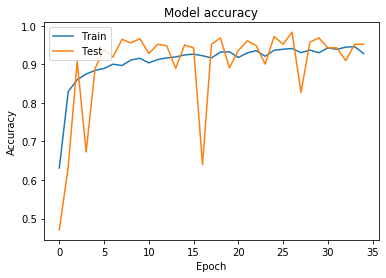

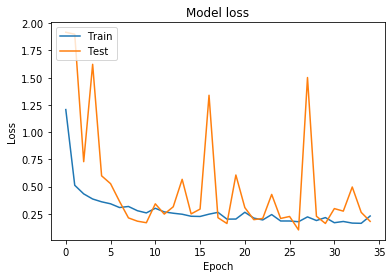

In [17]:
# Plot training & validation accuracy values
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch') 
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [18]:
model.save("resNext6")

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: resNext6\assets


In [ ]:

new_model = tf.keras.models.load_model('resnet_cw')

# Check its architecture
new_model.summary()

In [19]:
eval_test_datagen = ImageDataGenerator(
#  featurewise_center=True,
#  featurewise_std_normalization=True,
rescale=1./255)

# set shuffle to False
eval_test_gen = eval_test_datagen.flow_from_directory(
                        directory=test_path, 
                        target_size=(160, 160), 
                        batch_size=32,
                        class_mode='categorical', 
                        shuffle=False)

model.evaluate(eval_test_gen)

Found 16588 images belonging to 4 classes.
  ...
    to  
  ['...']
519/519 [==============================] - 114s 221ms/step - loss: 0.1967 - categorical_accuracy: 0.9318


[0.19666674708242296, 0.9318182]

In [20]:

test_data = []
test_labels = []

cls_mapping = {'/NORMAL/': 0, 
               '/DME/':    1, 
               '/DRUSEN/': 2, 
               '/CNV/':    3}

for cls in ['/NORMAL/', '/DME/', '/DRUSEN/', '/CNV/']:
        for img in (os.listdir(test_path + cls)):
            img = plt.imread(test_path + cls + img)
            img = cv2.resize(img, (160, 160))
            img = np.dstack([img, img, img])
            
            img = img.astype('float32') / 255
            label = cls_mapping.get(cls, 0)
            
            test_data.append(img)
            test_labels.append(label)

test_data = np.array(test_data)
test_labels = np.array(test_labels)

#conf = confusion_matrix(test_labels, pred_ys)

In [21]:
Y = model.predict(test_data,batch_size = 32)
y_pred = np.argmax(Y,axis = 1)
print(test_labels)
print(y_pred)
num_errors = 0
print(len(y_pred))
for i in range(len(y_pred)):
    if y_pred[i] != test_labels[i]:
        num_errors += 1
        print("found another error, error count : ", num_errors)

[0 0 0 ... 3 3 3]
[0 0 2 ... 3 3 3]
16588
found another error, error count :  1
found another error, error count :  2
found another error, error count :  3
found another error, error count :  4
found another error, error count :  5
found another error, error count :  6
found another error, error count :  7
found another error, error count :  8
found another error, error count :  9
found another error, error count :  10
found another error, error count :  11
found another error, error count :  12
found another error, error count :  13
found another error, error count :  14
found another error, error count :  15
found another error, error count :  16
found another error, error count :  17
found another error, error count :  18
found another error, error count :  19
found another error, error count :  20
found another error, error count :  21
found another error, error count :  22
found another error, error count :  23
found another error, error count :  24
found another error, error coun

In [22]:
from sklearn.metrics import confusion_matrix
conf = confusion_matrix(test_labels, y_pred)

print(conf)

[[6076  114  506   10]
 [  21 2295   11   75]
 [  52   18 1836   56]
 [   8   94  105 5311]]
